# Preprocessing

In [1]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")
sns.set_palette('colorblind')
palette = sns.color_palette("colorblind")
#sns.palplot(palette)

def preprocess(df):
    df['scale'] = df['scale'].astype(str)
    df['ver']=df['ver'].replace('p2d2.optimizer', 'p2d2')
    df['ver']=df['ver'].replace('p2d2.no_optimizer', 'pandas')

dependent_variables = ['wall_time','mem_usage','net_usage','cpu_utilization','opt_time']
factors=['scale', 'ver', 'net', 'index', 'wflow']

df=pandas.read_csv('bench_results_max.csv')
preprocess(df)

# make oom's zero
df.loc[df['oom'] == True, dependent_variables] = 0
df.head(2)
#df.dtypes

,oom,opt_time,rep,wall_time,cpu_utilization,mem_usage,net_usage,ver,index,net,scale,wflow
0,False,0.697751,0,794.595709,0,502,0,p2d2,True,lan,1,agg.py
1,False,0.697751,1,794.595709,0,502,0,p2d2,True,lan,1,agg.py


In [2]:
# make sure oom is the same in all repetitions
#df.loc[0, 'oom']=True # used to test code below

ooms = df.pivot(index=set(df.columns)-{'rep'}, columns='rep', values='oom')
bitmask = ooms[0]==ooms[1]
assert bitmask.all()

# Calculate Speedup

In [3]:
df_mean=df.drop('rep', axis=1).groupby(factors).mean().reset_index()
df_mean

,scale,ver,net,index,wflow,oom,opt_time,wall_time,cpu_utilization,mem_usage,net_usage
0,1,p2d2,lan,False,agg.py,False,0.154965,12.192408,0,359,0
1,1,p2d2,lan,False,join.py,False,0.000971,16.101828,0,2752,0
2,1,p2d2,lan,False,proj.py,False,0.000810,8.963662,0,1775,0
3,1,p2d2,lan,False,sel.py,False,0.001291,48.018912,0,8031,0
4,1,p2d2,lan,True,agg.py,False,0.697751,794.595709,0,502,0
...,...,...,...,...,...,...,...,...,...,...,...
91,10,pandas,wan,False,sel.py,True,0.000000,0.000000,0,0,0
92,10,pandas,wan,True,agg.py,True,0.000000,0.000000,0,0,0
93,10,pandas,wan,True,join.py,False,0.024301,209.242556,0,13444,0
94,10,pandas,wan,True,proj.py,True,0.000000,0.000000,0,0,0


In [4]:
#calculate profit
df_diff=df_mean.pivot(index=['scale','net','index','wflow'],columns='ver', values=['wall_time','mem_usage', 'net_usage'])
for var in df_diff.columns.levels[0]:
    df_diff['diff_'+var]=df_diff[var]['pandas']-df_diff[var]['p2d2']
df_diff.head(2)

wall_time             mem_usage         net_usage  \
ver                           p2d2      pandas      p2d2  pandas      p2d2   
scale net index wflow                                                        
1     lan False agg.py   12.192408  229.607788     359.0  9132.0       0.0   
                join.py  16.101828   15.117945    2752.0  1414.0       0.0   

                               diff_wall_time diff_mem_usage diff_net_usage  
ver                     pandas                                               
scale net index wflow                                                        
1     lan False agg.py     0.0     217.415381         8773.0            0.0  
                join.py    0.0      -0.983883        -1338.0            0.0

In [5]:
df_diff=df_diff.reset_index().drop(['wall_time','mem_usage','net_usage'], axis='columns', level=0)
df_diff=df_diff.droplevel(level=1, axis='columns')
df_diff.head(2)

,scale,net,index,wflow,diff_wall_time,diff_mem_usage,diff_net_usage
0,1,lan,False,agg.py,217.415381,8773.0,0.0
1,1,lan,False,join.py,-0.983883,-1338.0,0.0


In [6]:
# overhead already in df
#df_diff['overhead'] = np.where(df_diff['opt'] == 'excl',
#                                           df_diff['diff_wall_time'] * -1,
#                                           df_diff['diff_wall_time'])

#overhead = df_diff.groupby(['scale','net','index']).agg(
#    {'overhead':np.sum})['overhead']

# Microbenchmarks

In [7]:
palette ={"pandas": "C3", "p2d2": "C2"}

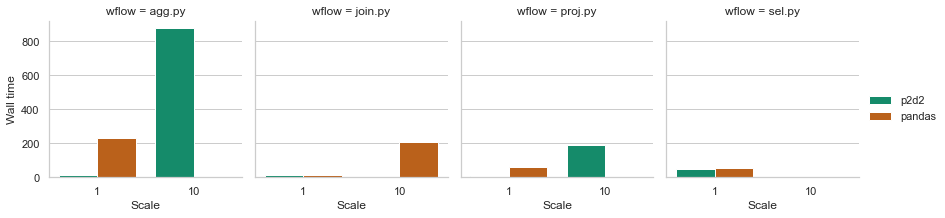

In [8]:
#logarithmic scale TODO
locnoind = df.query('index==False and net=="loc"')
g = sns.FacetGrid(locnoind, col="wflow")
g.map_dataframe(sns.barplot, x="scale", y='wall_time', hue='ver', palette=palette)
g.set_axis_labels("Scale", "Wall time")
g.add_legend()

## Operations that ran out of memory:

In [9]:
locnoind.query('rep==0 and oom==True')[['ver','wflow','scale']].sort_values(by=['ver'])

,ver,wflow,scale
92,p2d2,join.py,10
188,p2d2,sel.py,10
46,pandas,agg.py,10
142,pandas,proj.py,10
190,pandas,sel.py,10


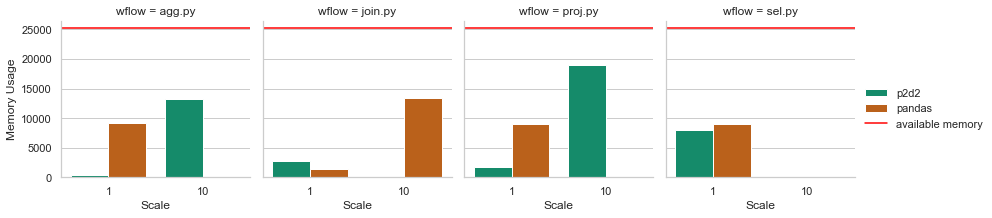

In [10]:
os_memory_overhead = 380
vagrant_maxmemory = 25576
vagrant_available = vagrant_maxmemory - os_memory_overhead
g = sns.FacetGrid(locnoind, col="wflow")
g.map_dataframe(sns.barplot, x="scale", y='mem_usage', hue='ver', palette=palette)
g.map(plt.axhline, y=vagrant_available, color='red', label=f'available memory')
g.set_axis_labels("Scale", "Memory Usage")
g.add_legend()

## Question time

- Should I say how I measured the memory usage?
- Is my method for measuring memory usage good enough?
- Is it OK to intentionally let pandas run out of memory (e.g. providing a limited amount of memory), so that the reader sees it's not just about optimizing, but also enabling

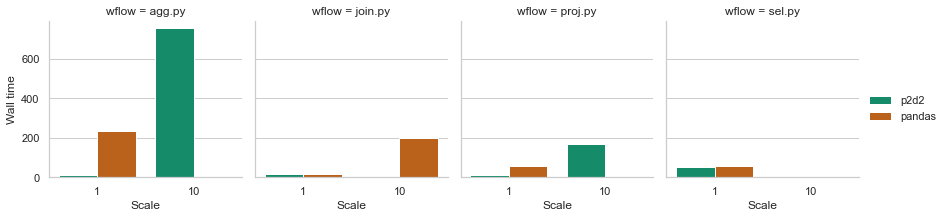

In [11]:
#logarithmic scale TODO
locnoind = df.query('index==True and net=="loc"')
g = sns.FacetGrid(locnoind, col="wflow")
g.map_dataframe(sns.barplot, x="scale", y='wall_time', hue='ver', palette=palette)
g.set_axis_labels("Scale", "Wall time")
g.add_legend()

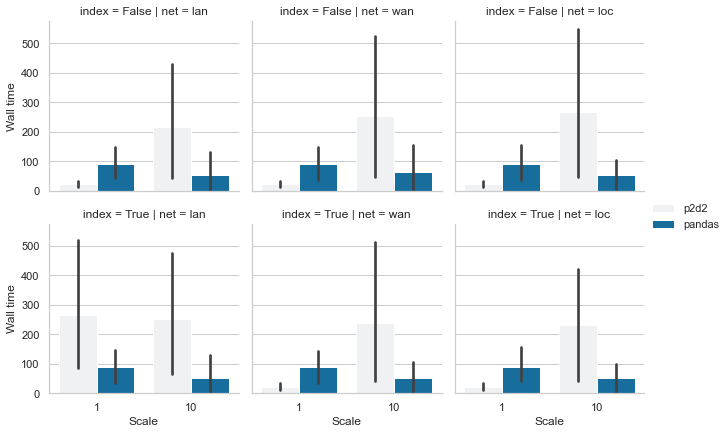

In [12]:
#logarithmic scale TODO
g = sns.FacetGrid(df, col="net",  row="index")
g.map_dataframe(sns.barplot, x="scale", y='wall_time', hue='ver')
g.set_axis_labels("Scale", "Wall time")
g.add_legend()

NameError: name 'overhead' is not defined

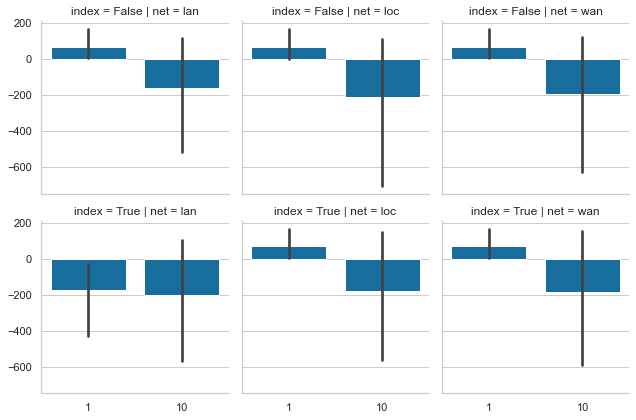

In [13]:
#speedup (different story)
g = sns.FacetGrid(df_diff, col="net",  row="index")
g.map_dataframe(sns.barplot, x="scale", y='diff_wall_time')
g.map(plt.axhline, y=overhead.mean(), color='red', label=f'E(overhead)={overhead.mean():.2f}')
g.set_axis_labels("Scale", "Gain")
plt.legend()

In [ ]:
#add overhead on the x-axis
df_diff_overhead=df_diff[df_diff['scale']=='1'].copy()
df_diff_overhead['scale']='overhead'
df_diff_overhead['diff_wall_time']=overhead.mean()
df_overhead_x = pandas.concat([df_diff, df_diff_overhead])

In [ ]:
#df_overhead_x=df_overhead_x.sort_values(by=['diff_wall_time'])
g = sns.FacetGrid(df_overhead_x, col="net",  row="index")
g.map_dataframe(sns.barplot, x="scale", y='diff_wall_time')
g.set_axis_labels("Scale & Overhead", "Gain")

In [ ]:
f, ax = plt.subplots(figsize=(16, 8))
lineplot=sns.lineplot(data=df, x="scale", y="wall_time", hue='vernet', style='index', err_style='bars')

In [ ]:
g = sns.FacetGrid(df, col="net",  row="index")
g.map_dataframe(sns.lineplot, x="scale", y='wall_time', hue='ver')
g.set_axis_labels("Scale", "Wall time")

In [ ]:
#better with the line
g = sns.FacetGrid(df_diff, col="net",  row="index")
g.map_dataframe(sns.lineplot, x="scale", y='diff_wall_time')
g.map(plt.axhline, y=overhead.mean(), color='red', label='overhead')
g.set_axis_labels("Scale", "Wall time")
plt.legend()

In [ ]:

#fig = lineplot.get_figure()
#fig.savefig('all.png') 